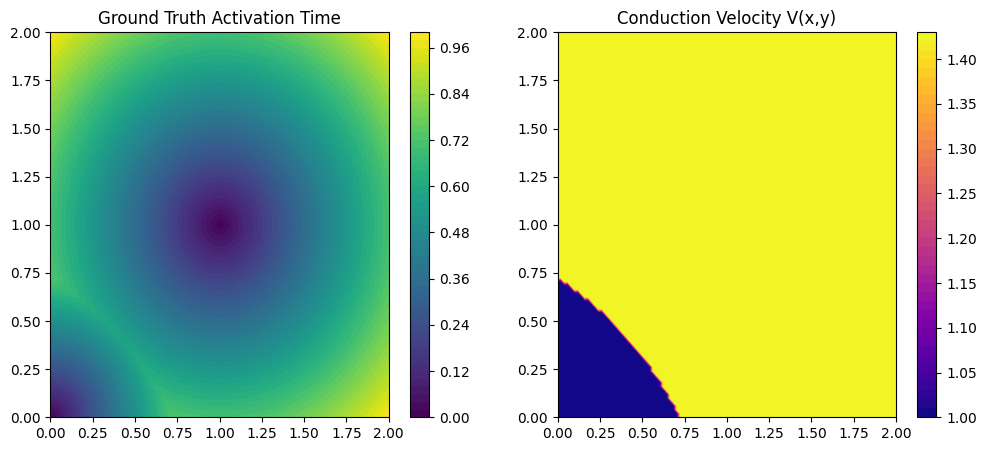

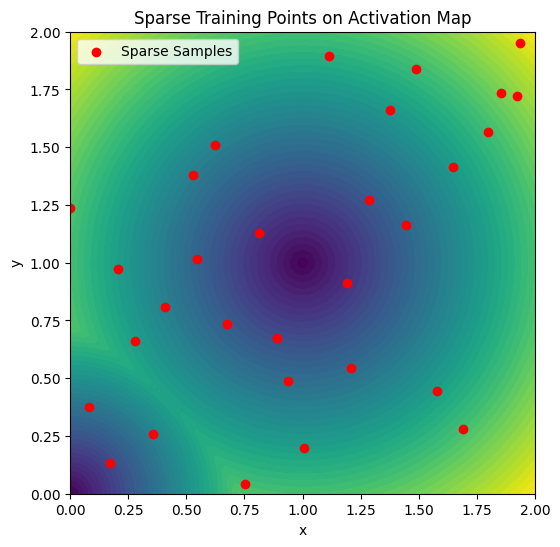

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Define the synthetic activation time function
def T_true(x, y):
    source1 = np.sqrt(x**2 + y**2)
    source2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.minimum(source1, source2)

# Define the conduction velocity function
def V(x, y):
    source1 = np.sqrt(x**2 + y**2)
    source2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(source1 < source2, 1.0, 1.0 / 0.7)

# Domain limits
xmin, xmax, ymin, ymax = 0, 2, 0, 2

# Generate a grid for plotting ground truth
grid_res = 100
x = np.linspace(xmin, xmax, grid_res)
y = np.linspace(ymin, ymax, grid_res)
X, Y = np.meshgrid(x, y)

T_exact = T_true(X, Y)
V_vals = V(X, Y)

# Plot ground truth activation time and velocity
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cs1 = axs[0].contourf(X, Y, T_exact, levels=50, cmap='viridis')
axs[0].set_title("Ground Truth Activation Time")
fig.colorbar(cs1, ax=axs[0])
cs2 = axs[1].contourf(X, Y, V_vals, levels=50, cmap='plasma')
axs[1].set_title("Conduction Velocity V(x,y)")
fig.colorbar(cs2, ax=axs[1])
plt.show()

# Generate sparse samples (e.g., 30) using Latin Hypercube Sampling
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=30)
sample_scaled = qmc.scale(sample, [xmin, ymin], [xmax, ymax])
x_train, y_train = sample_scaled[:, 0], sample_scaled[:, 1]
t_train = T_true(x_train, y_train)

# Visualize sparse points
plt.figure(figsize=(6, 6))
plt.contourf(X, Y, T_exact, levels=50, cmap='viridis')
plt.scatter(x_train, y_train, c='r', label='Sparse Samples')
plt.title("Sparse Training Points on Activation Map")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()




# Part B: Two Neural Network Models

Step 1: Build a Feedforward Neural Network.
Step 2: Define Two Models.

    Model 1: Data-driven Neural Network (NN) trained with Mean Squared Error (MSE) loss.

    Model 2: Physics-Informed Neural Network (PINN) minimizing the residual:

Step 3: Use Autograd to Compute Gradient
In PyTorch, we use torch.autograd.grad to compute the gradient norm:



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import qmc

# ======= Device =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Define conduction velocity V(x, y) =======
def V_numpy(x, y):
    source1 = np.sqrt(x**2 + y**2)
    source2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(source1 < source2, 1.0, 1.0 / 0.7)

def V_torch(x, y):
    source1 = torch.sqrt(x**2 + y**2)
    source2 = 0.7 * torch.sqrt((x - 1)**2 + (y - 1)**2)
    return torch.where(source1 < source2, torch.tensor(1.0, device=device), torch.tensor(1.0 / 0.7, device=device))

# ======= Define feedforward neural network =======
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# ======= Generate training data =======
def T_true_np(x, y):
    return np.minimum(np.sqrt(x**2 + y**2), 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2))

# Sparse data
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=30)
sample_scaled = qmc.scale(sample, [0, 0], [2, 2])
x_train = sample_scaled[:, 0]
y_train = sample_scaled[:, 1]
t_train = T_true_np(x_train, y_train)

X_train_tensor = torch.tensor(np.stack([x_train, y_train], axis=1), dtype=torch.float32, device=device)
T_train_tensor = torch.tensor(t_train, dtype=torch.float32, device=device).unsqueeze(1)

# Physics residual points (more than data points)
sample_phys = sampler.random(n=1000)
sample_phys_scaled = qmc.scale(sample_phys, [0, 0], [2, 2])
X_phys_tensor = torch.tensor(sample_phys_scaled, dtype=torch.float32, device=device)
X_phys_tensor.requires_grad_(True)

# ======= Initialize model and optimizer =======
model2 = MLP().to(device)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

# Loss weights
alpha = 1.0  # weight for physics loss
beta = 0.5   # weight for data MSE

# ======= Training loop =======
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # === Physics loss ===
    T_phys_pred = model2(X_phys_tensor).squeeze()

    grads = torch.autograd.grad(
        T_phys_pred,
        X_phys_tensor,
        grad_outputs=torch.ones_like(T_phys_pred),
        create_graph=True
    )[0]

    T_x, T_y = grads[:, 0], grads[:, 1]
    grad_norm = torch.sqrt(T_x**2 + T_y**2 + 1e-10)

    V_vals = V_torch(X_phys_tensor[:, 0], X_phys_tensor[:, 1])
    loss_phys = torch.mean((V_vals * grad_norm - 1.0) ** 2)

    # === Data loss ===
    T_data_pred = model2(X_train_tensor)
    loss_data = nn.MSELoss()(T_data_pred, T_train_tensor)

    # === Total loss ===
    loss = alpha * loss_phys + beta * loss_data
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, Physics = {loss_phys.item():.6f}, Data = {loss_data.item():.6f}")


Epoch 0: Total Loss = 0.929563, Physics = 0.885860, Data = 0.087405
Epoch 500: Total Loss = 0.065796, Physics = 0.018858, Data = 0.093874
Epoch 1000: Total Loss = 0.011663, Physics = 0.008759, Data = 0.005808
Epoch 1500: Total Loss = 0.008724, Physics = 0.006527, Data = 0.004393
Epoch 2000: Total Loss = 0.007346, Physics = 0.005278, Data = 0.004135
Epoch 2500: Total Loss = 0.005509, Physics = 0.003049, Data = 0.004920
Epoch 3000: Total Loss = 0.004649, Physics = 0.002638, Data = 0.004022
Epoch 3500: Total Loss = 0.003706, Physics = 0.002150, Data = 0.003111
Epoch 4000: Total Loss = 0.003282, Physics = 0.001829, Data = 0.002905
Epoch 4500: Total Loss = 0.002903, Physics = 0.001524, Data = 0.002759


# Code to Add After Training Models

In [12]:
# === Create dense grid ===
grid_res = 100
x = np.linspace(0, 2, grid_res)
y = np.linspace(0, 2, grid_res)
X, Y = np.meshgrid(x, y)
XY_grid = np.column_stack((X.flatten(), Y.flatten()))
XY_torch = torch.tensor(XY_grid, dtype=torch.float32, device=device)

# === Predict with both models ===
model1.eval()
model2.eval()
with torch.no_grad():
    T_pred1 = model1(XY_torch).cpu().numpy().reshape(grid_res, grid_res)
    T_pred2 = model2(XY_torch).cpu().numpy().reshape(grid_res, grid_res)

# === Ground truth ===
T_true_grid = T_true_np(X, Y)

# === RMSE Calculation ===
rmse1 = np.sqrt(np.mean((T_pred1 - T_true_grid) ** 2))
rmse2 = np.sqrt(np.mean((T_pred2 - T_true_grid) ** 2))
print(f"RMSE Model 1 (Data-only): {rmse1:.4f}")
print(f"RMSE Model 2 (PINN): {rmse2:.4f}")


RMSE Model 1 (Data-only): 0.0381
RMSE Model 2 (PINN): 0.1418


# Visualization Code

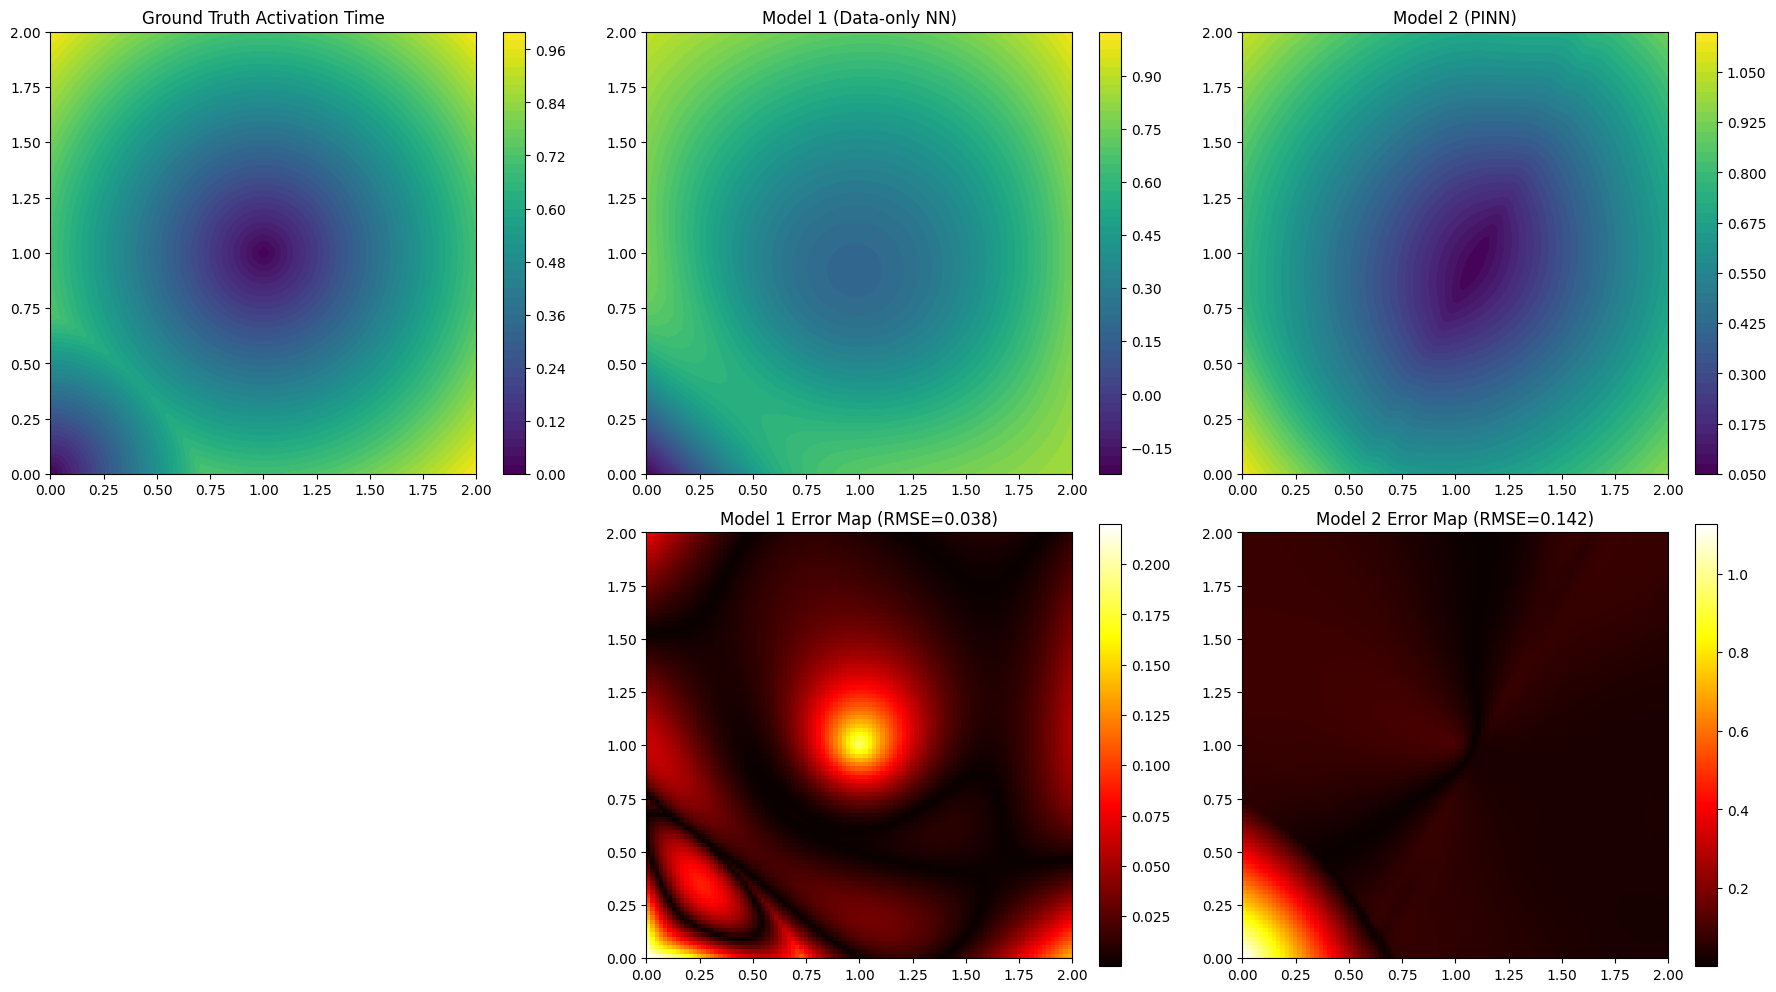

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Ground truth
cs0 = axs[0, 0].contourf(X, Y, T_true_grid, 50, cmap='viridis')
axs[0, 0].set_title("Ground Truth Activation Time")
plt.colorbar(cs0, ax=axs[0, 0])

# Model 1 prediction
cs1 = axs[0, 1].contourf(X, Y, T_pred1, 50, cmap='viridis')
axs[0, 1].set_title("Model 1 (Data-only NN)")
plt.colorbar(cs1, ax=axs[0, 1])

# Model 2 prediction
cs2 = axs[0, 2].contourf(X, Y, T_pred2, 50, cmap='viridis')
axs[0, 2].set_title("Model 2 (PINN)")
plt.colorbar(cs2, ax=axs[0, 2])

# Error maps
err1 = np.abs(T_pred1 - T_true_grid)
err2 = np.abs(T_pred2 - T_true_grid)

cs3 = axs[1, 1].imshow(err1, extent=[0, 2, 0, 2], origin='lower', cmap='hot')
axs[1, 1].set_title(f"Model 1 Error Map (RMSE={rmse1:.3f})")
plt.colorbar(cs3, ax=axs[1, 1])

cs4 = axs[1, 2].imshow(err2, extent=[0, 2, 0, 2], origin='lower', cmap='hot')
axs[1, 2].set_title(f"Model 2 Error Map (RMSE={rmse2:.3f})")
plt.colorbar(cs4, ax=axs[1, 2])

# Empty for spacing
axs[1, 0].axis('off')

plt.tight_layout()
plt.show()
